In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp

# Useful definitions 
# Photometry: 
# http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/516016.pdf
# https://www.mso.anu.edu.au/~amedling/obstech/obstech_5_fluxes.pdf
# ESA Land Observations: https://earth.esa.int/landtraining09/D1Lb1_PotuckovaOpticalBasics.pdf
# https://arxiv.org/pdf/1507.03578.pdf

# Moon and Earth parameters:
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html

# Physical Constants 
R_earth = 6371E+3 # Radius of the Earth, m
R_moon = 1738.2E+3 # Radius of the Moon, m (Allen 1976)
d_moon_earth = 384400E+3 # Distance Moon - Earth, m 
h_sat = 600E+3 # Altitude of the spacecraft, m
cs = 299792458. # Speed of light, m/s
h = 6.62607004E-34 # Planck's constant m2 kg / s
albedo_earth = 0.434 # Average value for the albedo of the Earth 
albedo_moon = 0.12 # Average value for the albedo of the Moon
d_sun_earth = 149597870E+3 # m

# Statistical constants 
sigma1=0.682689492137086 
sigma2=0.954499736103642 
sigma3=0.997300203936740 

In [2]:
## Functions ## 
# This needs to be periodically dumped to a tools.py file 

# Cheatsheet
# AB mag in W/Hz/m2: mAB = -2.5*log10(f) - 56.1  

def flux2mag(flux): 
    # Input flux in W/m2/Hz
    # Output magAB 
    # Ref: http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/516016.pdf
    return(-2.5*np.log10(flux) - 56.1)

def mag2flux(mag): 
    # Output flux in W/m2/Hz 
    # Input magAB 
    # Ref: http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/516016.pdf
    return(10**((-56.1-mag)/2.5))

def flux_freq2wave(flux, lambda_ref):
    # Fλ  = Fν c / λ2  
    # Input: flux in W/m2/Hz, lambda_ref in m
    # Output: flux in W/m2/m
    return(cs*flux/lambda_ref**2)

def flux_wave2freq(flux, lambda_ref):
    # Fν    =    Fλ    λ2/c   
    # Input: flux in W/m2/m, lambda_ref in m
    # Output: flux in W/m2/Hz
    return(flux*lambda_ref**2/cs)

def angular_radius_earth_from_orbit(h_sat):
    # Input - Orbit altitude
    # Output - Apparent angular size of the Earth from orbit in degrees
    return(np.degrees(np.arctan(R_earth/(R_earth+h_sat))))




def sb_sunlit_moon(mag_sun, d_moon_obs):
    # Input: 
    # mag_sun: Apparent magnitude of the sun  
    # d_moon_observer: Distance of the observer to the surface of the Earth
    
    # This is the flux that arrives to Earth, the Solar Constant 
    flux_sun_at_moon = mag2flux(mag_sun) # W / m2 / Hz - We can aprox that it is the same for Moon and Earth
    
    # The Earth cross section is R_earth**2 * pi
    # Then the light has to illuminate half of the sphere until R_moon + h, times the albedo
    sunflux_reflected_by_moon = albedo_moon*flux_sun_at_moon*R_moon**2/(2*(R_moon+d_moon_obs)**2)
    
    # The angular radius of the earth in degrees as defined by the function 
    angular_radius_moon_from_obs = np.degrees(np.arctan(R_moon/(R_moon+d_moon_obs)))
    
    # The area is just r**2 * pi, times 3600**2 to switch from deg**2 to arcsec**2
    area_moon_from_obs = np.pi*angular_radius_moon_from_obs**2*3600**2
    
    # The surface brightness intensity is:
    sb_intensity = sunflux_reflected_by_moon/area_moon_from_obs
    return(sb_intensity)


def sb_sunlit_earth(mag_sun, d_earth_obs):
    # Input: 
    # mag_sun: Apparent magnitude of the sun  
    # albedo_earth: Albedo of the Earth
    # d_earth_observer: Distance of the observer to the surface of the Earth
    
    # This is the flux that arrives to Earth, the Solar Constant 
    flux_sun_at_earth = mag2flux(mag_sun) # W / m2 / Hz
    
    # The Earth cross section is R_earth**2 * pi
    # Then the light has to illuminate half of the sphere until R_earth + h, times the albedo
    sunflux_reflected_by_earth = albedo_earth*flux_sun_at_earth*R_earth**2/(2*(R_earth+d_earth_obs)**2)
    
    # The angular radius of the earth in degrees as defined by the function 
    angular_radius_earth_from_obs = angular_radius_earth_from_orbit(d_earth_obs)
    
    # The area is just r**2 * pi, times 3600**2 to switch from deg**2 to arcsec**2
    area_earth_from_obs = np.pi*angular_radius_earth_from_obs**2*3600**2
    
    # The surface brightness intensity is:
    sb_intensity = sunflux_reflected_by_earth/area_earth_from_obs
    return(sb_intensity)


def sb_moonlit_earth(mag_sun, d_earth_obs):
    # Input: 
    # mag_sun: Apparent magnitude of the sun  
    # d_earth_observer: Distance of the observer to the surface of the Earth
    
    # This is the flux that arrives to Earth, the Solar Constant 
    flux_sun_at_moon = mag2flux(mag_sun) # W / m2 / Hz
    
    # The Earth cross section is R_earth**2 * pi
    # Then the light has to illuminate half of the sphere until R_earth + h, times the albedo
    sunflux_reflected_by_moon_to_earth = albedo_moon*flux_sun_at_moon*R_moon**2/(2*(d_moon_earth)**2)

    # The intensity received by Earth from the full moon is
    I_moon_earth = sunflux_reflected_by_moon_to_earth*np.pi*R_earth**2

    # The flux of the night side of the Earth illuminated by the Moon at an altitude h_sat is:
    f_earthshine_moonlit = albedo_earth*I_moon_earth/(2*np.pi*(R_earth + d_earth_obs)**2)    
    
    # The angular radius of the earth in degrees as defined by the function 
    angular_radius_earth_from_obs = angular_radius_earth_from_orbit(d_earth_obs)
    
    # The area is just r**2 * pi, times 3600**2 to switch from deg**2 to arcsec**2
    area_earth_from_obs = np.pi*angular_radius_earth_from_obs**2*3600**2
    
    # The surface brightness intensity is:
    sb_intensity = f_earthshine_moonlit/area_earth_from_obs
    return(sb_intensity)

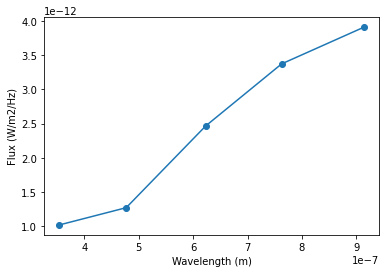

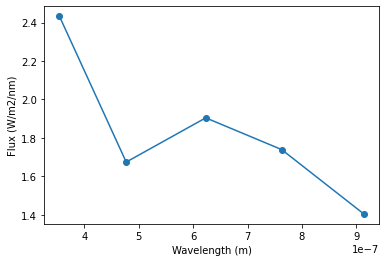

In [3]:
###################################
# Sun photometric characteristics #
###################################
# Apparent magnitude of the Sun -  Bohlin and Gilliland 2004 
u_sun = -26.12 # AB mag
g_sun = -26.36 # AB mag
r_sun = -27.08 # AB mag
i_sun = -27.42 # AB mag 
z_sun = -27.58 # AB mag

u_l = 3543E-10 # m
g_l = 4770E-10 # m
r_l = 6231E-10 # m
i_l = 7625E-10 # m
z_l = 9134E-10 # m

sun_mag = np.array([u_sun, g_sun, r_sun, i_sun, z_sun])
sun_wave = np.array([u_l, g_l, r_l, i_l, z_l])
sun_flux = mag2flux(np.array([u_sun, g_sun, r_sun, i_sun, z_sun]))

plt.plot(sun_wave, mag2flux(sun_mag))
plt.scatter(sun_wave, mag2flux(sun_mag))
plt.xlabel("Wavelength (m)")
plt.ylabel("Flux (W/m2/Hz)")
plt.show()

# Most plots of the Sun spectrum are in W/m2/nm so lets switch from frequency to wavelength 
plt.plot(sun_wave, 1E-9*flux_freq2wave(mag2flux(sun_mag), sun_wave))
plt.scatter(sun_wave, 1E-9*flux_freq2wave(mag2flux(sun_mag), sun_wave))
plt.xlabel("Wavelength (m)")
plt.ylabel("Flux (W/m2/nm)")
plt.show()

# Note: 
# The approximate flux from the sun at optical frequencies is ~ 2 W/m2/nm, so we are ok up to this point
##################################

In [4]:
# Surface brightness of the sunlit Earth
print("Surface brightness of the sunlit Earth")
print(flux2mag(sb_sunlit_earth(mag_sun=sun_mag, d_earth_obs=d_moon_earth)))

# Surface brightness of the Moonlit Earth
print("Surface brightness of the Moonlit Earth")
print(flux2mag(sb_moonlit_earth(mag_sun=sun_mag, d_earth_obs=d_moon_earth)))

# Surface brightness of the Sunlit Moon
print("urface brightness of the Sunlit Moon")
print(flux2mag(sb_sunlit_moon(mag_sun=sun_mag, d_moon_obs=d_moon_earth)))

Surface brightness of the sunlit Earth
[3.35365864 3.11365864 2.39365864 2.05365864 1.89365864]
Surface brightness of the Moonlit Earth
[18.13169868 17.89169868 17.17169868 16.83169868 16.67169868]
urface brightness of the Sunlit Moon
[4.74960755 4.50960755 3.78960755 3.44960755 3.28960755]


In [5]:
# Magnitude of the Moon if it was a perfect reflector 
I_sun_moon = sun_flux*np.pi*R_moon**2
f_moonshine = albedo_moon*I_sun_moon/(2*np.pi*(d_moon_earth)**2)
print("Magnitude of the Moon from the Earth")
print(flux2mag(f_moonshine))

print("Official value mag(V moon)= -12.74")

Magnitude of the Moon from the Earth
[-11.34195996 -11.58195996 -12.30195996 -12.64195996 -12.80195996]
Official value mag(V moon)= -12.74


In [7]:
# Magnitude of the sunlit Earth from a satellite at 600 km

I_sun_earth = sun_flux*np.pi*R_earth**2
f_earthshine_sunlit = albedo_earth*I_sun_earth/(2*np.pi*(R_earth + h_sat)**2)
print("Magnitude of the sunlit Earth from a satellite")
print(flux2mag(f_earthshine_sunlit))

# Surface brightness magnitude of the Sunlit earth
# Earth parameters 

# First we calculate the angular radius of the Earth from the satelite
earth_theta = angular_radius_earth_from_orbit(h_sat) # Visible angle of the radius of the Earth, radians
print("Angular radius of the earth from satellite perspective: " + str(earth_theta))

# Then we estimate the area
area_earth = (earth_theta)**2*np.pi # Area occupied by the surface of the Earth deg^2
print("Area earth: " + str(area_earth) + " degrees^2")

# We smear all the flux over the surface 
mu_earthshine_sunlit = -2.5*np.log10(f_earthshine_sunlit/(area_earth*3600*3600)) - 56.1
print("Surface brightness magnitude of the sunlit Earth from a satellite")
print(mu_earthshine_sunlit)

Magnitude of the sunlit Earth from a satellite
[-24.26571195 -24.50571195 -25.22571195 -25.56571195 -25.72571195]
Angular radius of the earth from satellite perspective: 42.42509960020493
Area earth: 5654.518298712408 degrees^2
Surface brightness magnitude of the sunlit Earth from a satellite
[2.89678959 2.65678959 1.93678959 1.59678959 1.43678959]


In [8]:
# TEST: Let's find out if our model is accurate enough. 
# Absolute magnitude of the FULL earth is -3.99 
# What is its surface brightness?

flux_at_1AU = mag2flux(-3.95)
earth_theta_1AU = angular_radius_earth_from_orbit(d_sun_earth) # Visible angle of the radius of the Earth, degrees
area_earth_1AU = (earth_theta_1AU)**2*np.pi # Area occupied by the surface of the Earth deg^2
print("Area earth: " + str(area_earth_1AU) + " degrees^2")

# We smear all the flux over the surface 
mu_earthshine_1AU = -2.5*np.log10(flux_at_1AU/(area_earth_1AU*3600*3600)) - 56.1
print("Surface brightness magnitude of the sunlit Earth from 1 AU")
print(mu_earthshine_1AU)

# It works! It is very similar to what we obtain with our approximations. 

Area earth: 1.8703485050859758e-05 degrees^2
Surface brightness magnitude of the sunlit Earth from 1 AU
2.0113188460251052


In [9]:
# Now let's do it for the Moonlit side of the Earth
I_moon_earth = f_moonshine*np.pi*R_earth**2
f_earthshine_moonlit = albedo_earth*I_moon_earth/(2*np.pi*(R_earth + h_sat)**2)
print("Magnitude of the moonlit Earth from a satellite")
print(flux2mag(f_earthshine_moonlit))

# We smear all the flux over the surface 
mu_earthshine_moonlit = -2.5*np.log10(f_earthshine_moonlit/(area_earth*3600*3600)) - 56.1
print("Surface brightness magnitude of the sunlit Earth from a satellite")
print(mu_earthshine_moonlit)


Magnitude of the moonlit Earth from a satellite
[ -9.48767191  -9.72767191 -10.44767191 -10.78767191 -10.94767191]
Surface brightness magnitude of the sunlit Earth from a satellite
[17.67482963 17.43482963 16.71482963 16.37482963 16.21482963]


In [14]:
# Montañes-Rodriguez, Pallé, Goode 2007. 
# The surface brightness of the Dark Side of the Moon is 15.44 mag/arcsec^2 in band V 
# Magnitude of the sunlit Earth from a satellite at 600 km

I_sun_earth = sun_flux*np.pi*R_earth**2
f_darkside_moon = albedo_earth*I_sun_earth/(2*np.pi*(d_moon_earth)**2)
I_darkside_moon = f_darkside_moon*np.pi*R_moon**2 
f_darkside_moon_backtoearth = albedo_moon*I_darkside_moon/(2*np.pi*(d_moon_earth)**2)

print("Magnitude of the Earthshine Dark side Moon from the Earth")
print(flux2mag(f_darkside_moon_backtoearth))

# Surface brightness magnitude of the Sunlit earth
# Earth parameters 

# First we calculate the angular radius of the Earth from the satelite
moon_theta_from_earth = np.degrees(np.arcsin(R_moon/d_moon_earth)) # Visible angle of the radius of the Earth, radians
print("Angular radius of the Moon from Earth perspective: " + str(moon_theta_from_earth))

# Then we estimate the area
area_moon = (moon_theta_from_earth)**2*np.pi # Area occupied by the surface of the Earth deg^2
print("Area moon: " + str(area_moon) + " degrees^2")

# We smear all the flux over the surface 
mu_darkside_moon_backtoearth = -2.5*np.log10(f_darkside_moon_backtoearth/(area_moon*3600*3600)) - 56.1
print("Surface brightness magnitude of the Dark Side of the Moon from Earth")
print(mu_darkside_moon_backtoearth)

print("\nMontañes-Rodriguez, Pallé, Goode 2007") 
print("The surface brightness of the Dark Side of the Moon is 15.44 mag/arcsec^2 in band V\n")      

# Now for the bright side of the Moon
mu_brightside_moon = -2.5*np.log10(f_moonshine/(area_moon*3600*3600)) - 56.1
print("Surface brightness magnitude of the Bright Side of the Moon from Earth")
print(mu_brightside_moon)

Magnitude of the Earthshine Dark side Moon from the Earth
[-0.37930924 -0.61930924 -1.33930924 -1.67930924 -1.83930924]
Angular radius of the Moon from Earth perspective: 0.2590839317027276
Area moon: 0.21087778476282146 degrees^2
Surface brightness magnitude of the Dark Side of the Moon from Earth
[15.71228034 15.47228034 14.75228034 14.41228034 14.25228034]

Montañes-Rodriguez, Pallé, Goode 2007
The surface brightness of the Dark Side of the Moon is 15.44 mag/arcsec^2 in band V

Surface brightness magnitude of the Bright Side of the Moon from Earth
[4.74962962 4.50962962 3.78962962 3.44962962 3.28962962]
